# TM10007 Assignment Head and Neck cancer Radiomics

Marie-Claire Doornbos ()
Julia Holdorp (4561651)
Quinten Mank (4336615)
Ylva Weeda ()

 

In [4]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [8]:
## Importing Modules

In [20]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve


## 1. Data loading


In [14]:
# Load data
from hn.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

if data.isnull().values.any():
    print('In the csv data file, some values are missing or NaN'), sys.exit


The number of samples: 113
The number of columns: 160


In [15]:
""" Extract feature values and labels """
# Features
features = data.loc[:, data.columns != 'label'].values
features = StandardScaler().fit_transform(features)

# Labels
labels = data.loc[:,['label']].values
labels = [item if item!='T12' else 0 for item in labels]
labels = [item if item!='T34' else 1 for item in labels]
labels = np.array(labels)
print(f'Number of high risk patients: {np.count_nonzero(labels)}') 
print(f'Number of low risk patients: {len(labels) - np.count_nonzero(labels)}')

Number of high risk patients: 55
Number of low risk patients: 58


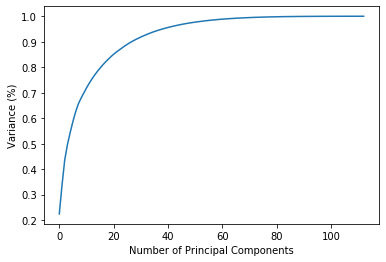

In [16]:
# Principle components 

filepath = '/Users/Julia/Desktop/Machine learning/TM10007_PROJECT/hn/HN_radiomicFeatures.csv' # Dit nog weg
data = np.genfromtxt(filepath, delimiter=',', dtype='float64')
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(data[1:,1:])
data_rescaled = np.nan_to_num(data_rescaled)

pca = PCA().fit(data_rescaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance (%)')
plt.show()

## 2. Preprocessing 
The data is split into feature values and labels (high risk or low risk). The amount of high-risk and low-risk patients is printed as an output. 
To optimize the machine learning algorithm, the features of the dataset are normalized using StandardScaler.
If the dataset contains any missing values or NaN, an error is printed and the algorithm stops.

- Handling missing data
- Implementing standard scalar on the data


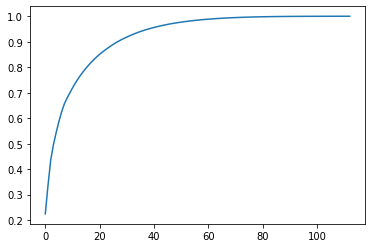

In [17]:
# 3. Feature selection
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [40]:
# Hier moet feature selection komen, weet alleen nog niet helemaal hoe...

In [22]:
# Splitting the data in a training and a test set 
def split_sets(features, labels):
    """
    Splits the features and labels into a training set (80%) and test set (20%)
    """
    x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=1)
    return x_train, x_test, y_train, y_test 

x_train, x_test, y_train, y_test = split_sets(features, labels) 

# The training set is again divided into a training and a validation set and afterwards classified using a leave one out validation and logistic regression.

def leave_one_out_val(x,y):
    """
    Leave One Out Cross Validation using Logistic Regression as a classifier
    """
    loo = LeaveOneOut()
    loo.get_n_splits(x,y)

    prediction = [] 
    y_val_total = []

    for train_index, val_index in loo.split(x,y):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val= y[train_index], y[val_index]

        if min(x_train.shape[0], x_train.shape[1]) < 70:
            print('Not enough input values for PCA with 70 components')
            sys.exit()
        else:
            pca = PCA(n_components=70)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_val = pca.transform(x_val)

            lrg= sklearn.linear_model.LogisticRegression()
            lrg.fit(x_train,y_train) 
    
            lrg_predicted=lrg.predict(x_val)
            prediction.append(lrg_predicted)
            y_val_total.append(y_val)
        accuracy = accuracy_score(y_val_total, prediction)

    return accuracy

accuracy = leave_one_out_val(x_train,y_train)
print(f'Leave one out cross validation accuracy: {accuracy}')

# The training set is again divided into a training and a validation set and afterwards classified using a Kfold cross validation and logistic regression.
def cross_val(x,y):
    """
    Cross validation using a Logistic Regression classifier (5 folds)
    """

    crss_val = RepeatedKFold(n_splits = 5, n_repeats=10, random_state = None)           
    crss_val.get_n_splits(x, y)

    performances = [] 

    for train_index, val_index in crss_val.split(x, y):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val= y[train_index], y[val_index]

        if min(x_train.shape[0], x_train.shape[1]) < 70:
            print('Not enough input values for PCA with 70 components')
            sys.exit()
        else:
            pca = PCA(n_components=70)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_val = pca.transform(x_val)

            lrg=sklearn.linear_model.LogisticRegression()
            lrg.fit(x_train,y_train) 
            prediction=lrg.predict(x_val)
            accuracy = accuracy_score(y_val, prediction)
            performances.append(accuracy)

    return performances

accuracy = cross_val(x_train, y_train)
print(f'KFold cross validation accuracies: {accuracy}')
print(f'Kfold cross validation average accuracy: {statistics.mean(accuracy)}')


NameError: name 'sklearn' is not defined

## 6. Evaluation
To evaluate the machine learning algoritm for the prediction of the T-score in head and neck cancer patients, different outcome measures are used: 
- boxplots
- confusion matrix 
- ROC curves


In [1]:
def plot_roc(y_test, y_score, n_components):
    """
    Plots ROC curves
    Function returns none
    """
    try:
        # Make dictionaries
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(1):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Create plots
        plt.figure()
        lw_ = 1
        plt.plot(fpr[0], tpr[0], color='darkorange',
                 lw=lw_, label='ROC curve (area = %0.2f)' % roc_auc[0])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw_, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver operating characteristic, {n_components}\
                  principle components')
        plt.legend(loc="lower right")
        plt.show(block=False)
        
    # Catch an unexpected error
    except Exception as error:
        print('Unexpected error:'+str(error))
        raise
    return None

# ROC_curve = plot_roc()

# Zoek even op wat y_test en y_score was
# Waar zie je heir number of components ((x_train.shape[0], x_train.shape[1])?)
